# BART BMM: 2D Inputs with K Models
### Author: John Yannotty
#### Date: 05/05/23

This example demonstrates the BART-BMM model on a 2-dimensional example with three different simulators. Assume the true system is defined by $$f_\dagger(x) = \sin(x_1) + \cos(x_2),$$ over the domain $(x_1,x_2) \in [-\pi,\pi]\times [-\pi,\pi]$.  Furthermore, consider a model set which defines $3$ simulators under consideration in terms of Taylor series expanions of $\sin(x_1)$ and $\cos(x_2).$ The simulators are defined by $h_1(x)$, $h_2(x)$, and $h_3(x)$ as shown below:


$$h_1(x) = \sum_{j=0}^7 \frac{s^{(j)}(x_1)}{j!}(x_1-\pi)^j + \sum_{k=0}^{10} \frac{c^{(k)}(x_2)}{k!}(x_2-\pi)^k$$  

$$h_2(x) = \sum_{j=0}^{13} \frac{s^{(j)}(x_1)}{j!}(x_1+\pi)^j + \sum_{k=0}^6 \frac{c^{(k)}(x_2)}{k!}(x_2+\pi)^k$$

$$h_3(x) = \sum_{j=0}^{7} \frac{s^{(j)}(x_1)}{j!}(x_1+\pi)^j + \sum_{k=0}^8 \frac{c^{(k)}(x_2)}{k!}(x_2-\pi)^k.$$

where $x = (x_1,x_2)$, $s^{(j)}(x_1)$ denotes the jth derivative of $\sin(x_1)$, and $c^{(k)}(x_1)$ denotes the kth derivative of $\cos(x_2)$. Each simulator is sumarized below:

* $h_1(x)$: taylor series expansions of $\sin(x_1)$ and $\cos(x_2)$ about $\pi$.
* $h_2(x)$: taylor series expansions of $\sin(x_1)$ and $\cos(x_2)$ about $-\pi$. The expansion of $\sin(x_1)$ is a high-fidelity approximation of $\sin(x_1)$ across the entire interval $[-\pi,\pi]$.
* $h_3(x)$: taylor series expansions of $\sin(x_1)$ about $-\pi$ and $\cos(x_2)$ about $\pi$. 

Each simulator is designed to provide a high-fidelity approximation of the true function across some subregion of the domain. For example, both terms in $h_1(x)$ are centered about $\pi$, hence it should provide a higher-fidelity approximation of $f_\dagger(x)$ in the upper right corner of the domain. The objective moving forward is to combine the information across the $3$ simulators to obtain a better global prediction and inference regarding where each model is locally accurate/inaccurate.


## Setup

Given the setup of the problem, we can now proceed with the code required for fitting the BMM model. The subsection imports the required libraries and sets the system path for the Taweret directory. We will use the `polynomial_models` and `trees` python modules defined in Taweret for this notebook. 

The `polynomial_models` module defines a set of toy models one can consider when testing out the Taweret software. For this example, we will be using the `sin_exp`, `cos_exp`, and `sin_cos_exp` which define classes for Taylor series expansions of $\sin(x)$, $\cos(x)$, and $\sin(x) + \cos(x)$.

The `trees` module defines the BART-BMM method, which is used to combine the simulators under consideration.



In [1]:
# Basic imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import random

# Get the current directory and extract the Taweret part
# The current directory should be of the form /..../Taweret/docs/source/notebooks
# where /.../ corresponds to your local directories.
cwd = os.getcwd()

# Get the first part of this path and append to the sys.path
tw_path = cwd.split("Taweret/")[0] + "Taweret"
sys.path.append(tw_path)

# Set the Taweret path
#sys.path.append('../../../../Taweret')

# Taweret imports
import Taweret.models.polynomial_models 
from Taweret.models.polynomial_models import sin_exp, cos_exp, sin_cos_exp
from Taweret.mix.trees import Trees


## Training Data

Prior to mixing, we can generate training data over a two-dimensional grid. This is done by first generating a set of training inputs using the `grid_2d_design(...)` function. The function generates points with a space filling design. The 2-dimensional input space is divided into a $n_1 \times n_2$ grid. Then, an input $x = (x_1,x_2)$ is randomly generated in each rectangle of the grid. This results in a total of $n = n_1n_2$ training points. 

The training points are passed through the true function of $f_\dagger(x) = \sin(x_1) + \cos(x_2)$. Then random noise is added to simulate observational data, $Y_1,\ldots,Y_n$. The example below generates data from 80 training points, though one can easily use a smaller or larger training set. 

In [2]:
## Functions for design points 
# n1 = number of bins in the x1 dimension
# n2 = number of bins in the x2 dimension
# n = n1*n2 is the total training size
def grid_2d_design(n1,n2, xmin = [-1,-1], xmax = [1,1]):
  # Generate n uniform rvs
  n = n1*n2
  ux = np.random.uniform(0,1,n)
  uy = np.random.uniform(0,1,n)

  # Dimensions for each rectangle
  x1_len = (xmax[0] - xmin[0])/n1
  x2_len = (xmax[1] - xmin[1])/n2
  xgrid = [[x, y] for x in range(n1) for y in range(n2)]
  xgrid = np.array(xgrid).transpose()

  # Get points
  x1 = ux*x1_len + x1_len*xgrid[0] + xmin[0]
  x2 = uy*x2_len + x2_len*xgrid[1] + xmin[1]

  # Join data
  xdata = np.array([x1,x2]).transpose()
  return xdata

The training inputs is generated over the rectanlge $[-\pi,\pi]^2$. The design points are shown in the figure below. Then, the observational data is independently generated according to 

$$Y_i \sim  N(f_\dagger(x_i),\sigma^2),$$

where $x_i = (x_{i1},x_{i2})$ is the ith training input for $i=1,\ldots,n$. In this example, $n = 80$.

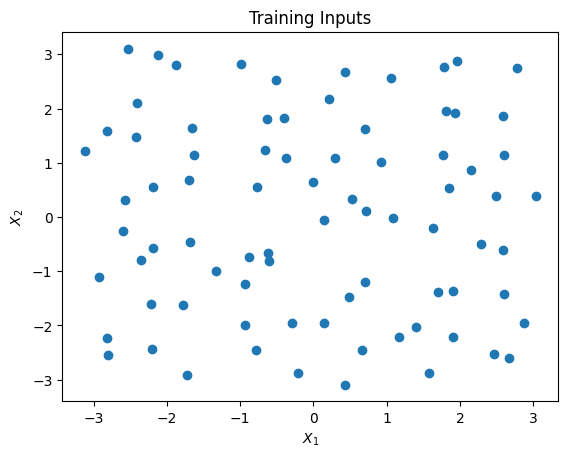

In [3]:
# Generate x's 
nx1 = 10; nx2 = 8
n_train = nx1*nx2
x_train = grid_2d_design(nx1,nx2,[-np.pi,-np.pi],[np.pi,np.pi])

# Generate y's
f0_train = np.sin(x_train.transpose()[0]) + np.cos(x_train.transpose()[1])
y_train = f0_train + np.random.normal(0,0.1,n_train)

# Visualize the design points
plt.scatter(x_train.transpose()[0],x_train.transpose()[1])
plt.title("Training Inputs")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()



### The Model Set

Now we can visualize the three expansions under consideration. Each surface is shown below. Note, the plots are truncated in areas where the expansion diverges. This is done only for visual purposes.

The first plot illustrates the true surface. This surface has various peaks and valleys across the input domain. We will see each simulator can be used to explain one of these features of the true surface. 

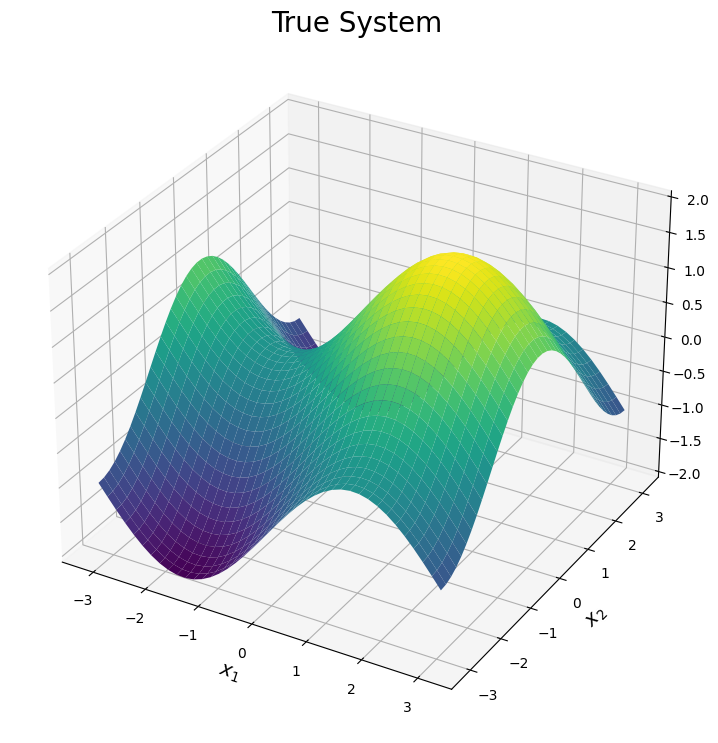

In [4]:
# Plot the surfaces
n_test = 40
x1_test = np.outer(np.linspace(-np.pi, np.pi, n_test), np.ones(n_test))
#x1_test = np.outer(np.linspace(-3, 3, n_test), np.ones(n_test))
x2_test = x1_test.copy().transpose()
f0_test = (np.sin(x1_test) + np.cos(x2_test))
x_test = np.array([x1_test.reshape(x1_test.size,),x2_test.reshape(x1_test.size,)]).transpose()

# Define color map
cmap = plt.get_cmap('viridis')

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x1_test, x2_test, f0_test, cmap = cmap, vmin = -2, vmax = 2)
plt.title("True System", size = 20)
plt.xlabel("$x_1$", size = 14)
plt.ylabel("$x_2$", size = 14)
ax.set_zlim([-2,2])

# show plot
plt.show()

#### The $h_1(x)$ surface

The first expansion is shown below. The predicted surface is accurate for points $(x_1,x_2)$ close to the point $(\pi,\pi)$. Based on the plot below, we can see the first expansion is designed to approximate the peak of the true system in this upper right corner of the domain. Meanwhile, the prediction diverges as $x_1$ or $x_2$ moves away from $\pi$. Note for visual purposes, the plot below truncates the approximation in these diverging regions. 

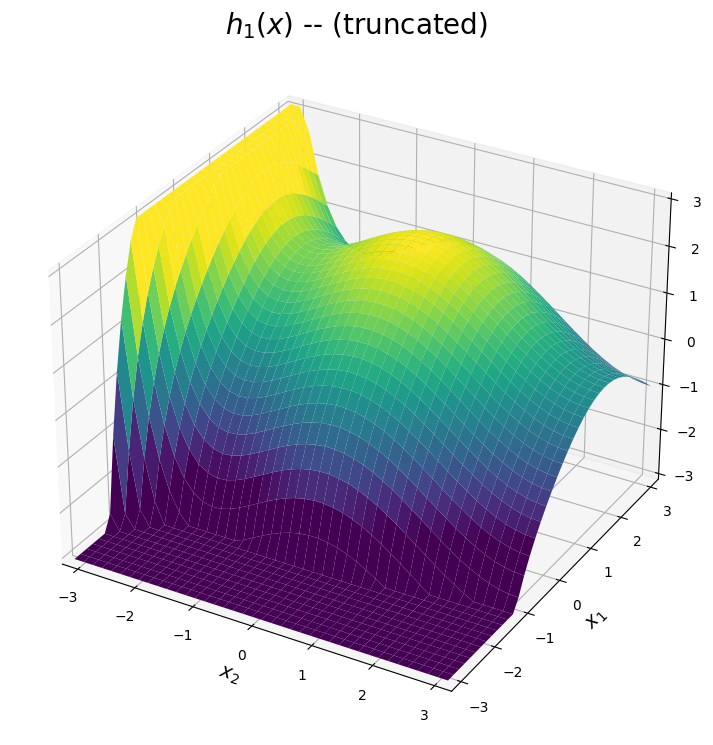

In [5]:
# Plot the first simulator
sin7 = sin_exp(7,np.pi)
cos10 = cos_exp(10,np.pi)

h1_sin = sin7.evaluate(x1_test.transpose()[0])[0]
h1_cos = cos10.evaluate(x1_test.transpose()[0])[0]

h1_sin_grid = np.outer(h1_sin, np.ones(n_test))
h1_cos_grid = np.outer(h1_cos, np.ones(n_test)).transpose()

h1_test = h1_sin_grid + h1_cos_grid

# Subset the data for the plot (only for visualization)
h1_test_filter = h1_test.copy()
for i in range(n_test):
    h1_test_filter[i][np.where(h1_test_filter[i]>3)] = 3.05
    h1_test_filter[i][np.where(h1_test_filter[i]<-3)] = -3.05
    
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x2_test, x1_test, h1_test_filter, cmap = cmap, vmin = -2, vmax = 2)
ax.set_zlim([-3,3])
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-np.pi,np.pi])
plt.title("$h_1(x)$ -- (truncated)", size = 20)
plt.xlabel("$x_2$", size = 14)
plt.ylabel("$x_1$", size = 14)

# show plot
plt.show()

#### The $h_2(x)$ surface

The second expansion is shown below. The predicted surface is accurate for points $(x_1,x_2)$ close to the point $(-\pi,-\pi)$. Additionally, the expansion of $\sin(x_1)$ is a high-fidelity apprixmation of $\sin(x_1)$ across the interval $[-\pi,\pi]$. Hence, from the plot below, $h_2(x)$ can be used to approximate the valley and curvature in the true function for points in the bottom region of the domain. Once again, the surface is truncated for visual purposes in regions where the expansion diverges. 

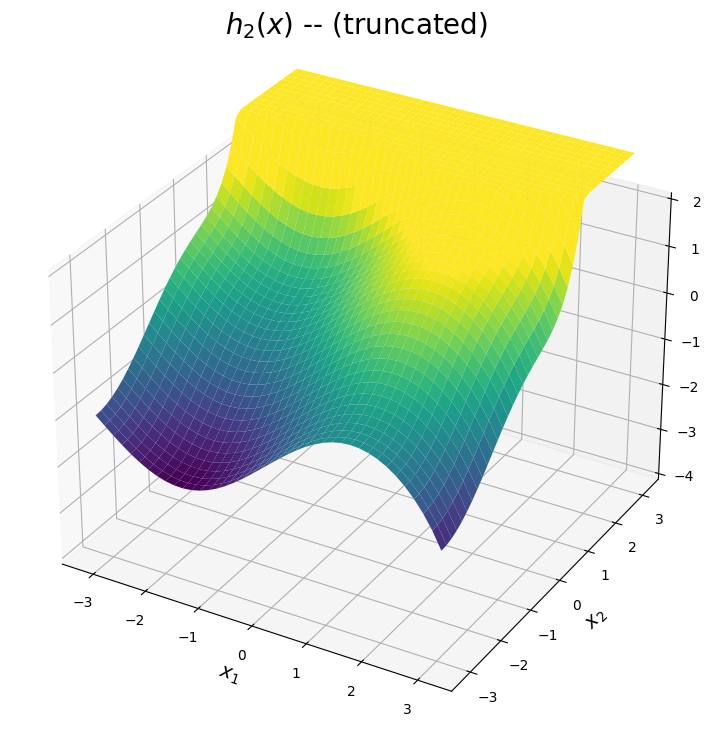

In [6]:
# Plot the second simulator
sin13 = sin_exp(13,-np.pi)
cos6 = cos_exp(6,-np.pi)

h2_sin = sin13.evaluate(x1_test.transpose()[0])[0]
h2_cos = cos6.evaluate(x1_test.transpose()[0])[0]

h2_sin_grid = np.outer(h2_sin, np.ones(n_test))
h2_cos_grid = np.outer(h2_cos, np.ones(n_test)).transpose()

h2_test = h2_sin_grid + h2_cos_grid

# Subset the data for the plot (only for visualization)
h2_test_filter = h2_test.copy()
for i in range(n_test):
    h2_test_filter[i][np.where(h2_test_filter[i]>3)] = 3.05
    h2_test_filter[i][np.where(h2_test_filter[i]<-3)] = -3.05


# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.set_zlim([-4,2])
ax.plot_surface(x1_test, x2_test, h2_test_filter,cmap = cmap, vmin = -2, vmax = 2)
plt.title("$h_2(x)$ -- (truncated)", size = 20)
plt.xlabel("$x_1$", size = 14)
plt.ylabel("$x_2$", size = 14)

# show plot
plt.show()

#### The $h_3(x)$ surface

The third expansion is shown below. The predicted surface is accurate for points $(x_1,x_2)$ close to the point $(-\pi,\pi)$, which corresponds to the top left corner of the domain. From the plot below, this expansion can be used to approximate the valley within the upper left corner.

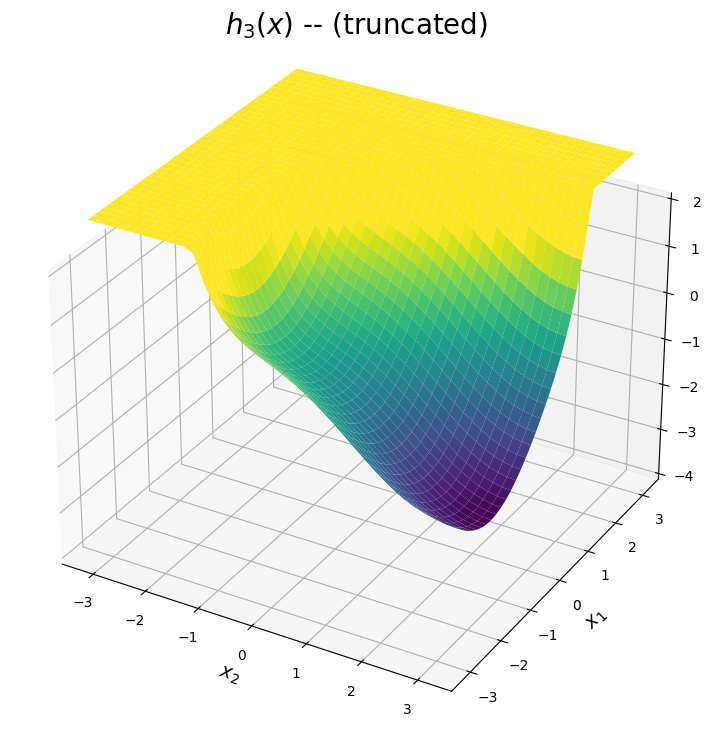

In [7]:
# Plot the second simulator
sin7_neg_pi = sin_exp(7,-np.pi)
cos8 = cos_exp(6,np.pi)

h3_sin = sin7_neg_pi.evaluate(x1_test.transpose()[0])[0]
h3_cos = cos8.evaluate(x1_test.transpose()[0])[0]

h3_sin_grid = np.outer(h3_sin, np.ones(n_test))
h3_cos_grid = np.outer(h3_cos, np.ones(n_test)).transpose()

h3_test = h3_sin_grid + h3_cos_grid

# Subset the data for the plot (only for visualization)
h3_test_filter = h3_test.copy()
for i in range(n_test):
    h3_test_filter[i][np.where(h3_test_filter[i]>3)] = 3.05
    h3_test_filter[i][np.where(h3_test_filter[i]<-3)] = -3.05


# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.set_zlim([-4,2])
ax.plot_surface(x2_test, x1_test, h3_test_filter,cmap = cmap, vmin = -2, vmax = 2)
plt.title("$h_3(x)$ -- (truncated)", size = 20)
plt.xlabel("$x_2$", size = 14)
plt.ylabel("$x_1$", size = 14)

# show plot
plt.show()

## The BART BMM Model

This section demonstrates how to train the BMM model for the 2D example. Note, it is assumed the software has been installed prior to running this notebook. If the software has not yet been installed, please follow the instructions under the Installation Section of the Taweret Documentation. 

In [8]:
# Define the model set
h1 = sin_cos_exp(7,10,np.pi,np.pi)
h2 = sin_cos_exp(13,6,-np.pi,-np.pi)
h3 = sin_cos_exp(7,8,-np.pi,np.pi)
model_dict = {'model1':h1, 'model2':h2, 'model3':h3}

#h1.evaluate([[np.pi,np.pi],[-np.pi,0]])[0]
#x2_test[0:5,0:5]


In [9]:
# Fit the BMM Model
# Initialize the Trees class instance
mix = Trees(model_dict = model_dict)

# Set prior information
mix.set_prior(k=2.5,ntree=10,overallnu=5,overallsd=0.01,inform_prior=False)

# Train the model
fit = mix.train(X=x_train, y=y_train, ndpost = 10000, nadapt = 2000, nskip = 2000, adaptevery = 500, minnumbot = 4, numcut = 100)


Results stored in temporary path: /tmp/openbtpy_cgeehvkf
Running model...


In [10]:
# Get predictions
ppost, pmean, pci, pstd = mix.predict(X = x_test, ci = 0.95)
wpost, wmean, wci, wstd = mix.predict_weights(X = x_test, ci = 0.95)


#### Predictions

The mean of the predicted surface from the BART-BMM model is shown below. From this plot, one can see the true surface is accurately recovered across the entire region of the domin. Since three expnansions are mixed, only 10 trees are needed to obtain such an accurate prediction.

(-2.5, 2.5)

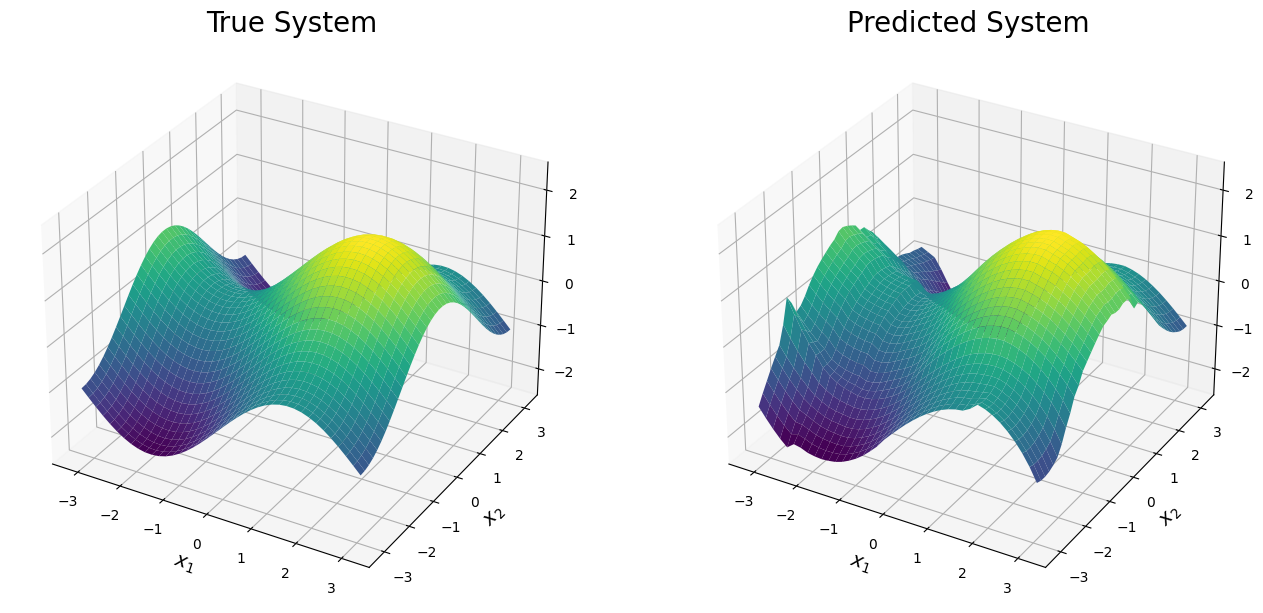

In [11]:
# Creating figure
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(x1_test, x2_test, f0_test, cmap = cmap, vmin = -2, vmax = 2)
ax.set_title("True System", size = 20)
ax.set_xlabel("$x_1$", size = 14)
ax.set_ylabel("$x_2$", size = 14)
ax.set_zlim([-2.5,2.5])

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x1_test, x2_test, pmean.reshape(x1_test.shape), cmap = cmap, vmin = -2, vmax = 2)
ax.set_title("Predicted System", size = 20)
ax.set_xlabel("$x_1$", size = 14)
ax.set_ylabel("$x_2$", size = 14)
ax.set_zlim([-2.5,2.5])


The posterior mean prediction and the true system are further compared below. Clearly, the mixed prediction combines the three expansions to accurately recover the true system. Each expansion is responsible for explaining one of the three main features of the true function.

* $h_1(x)$: Explains the peak of the system (yellow).
* $h_2(x)$: Explains the bottom left saddle point of the system (dark blue).
* $h_3(x)$: Explains the top right saddle point of the system (dark blue).

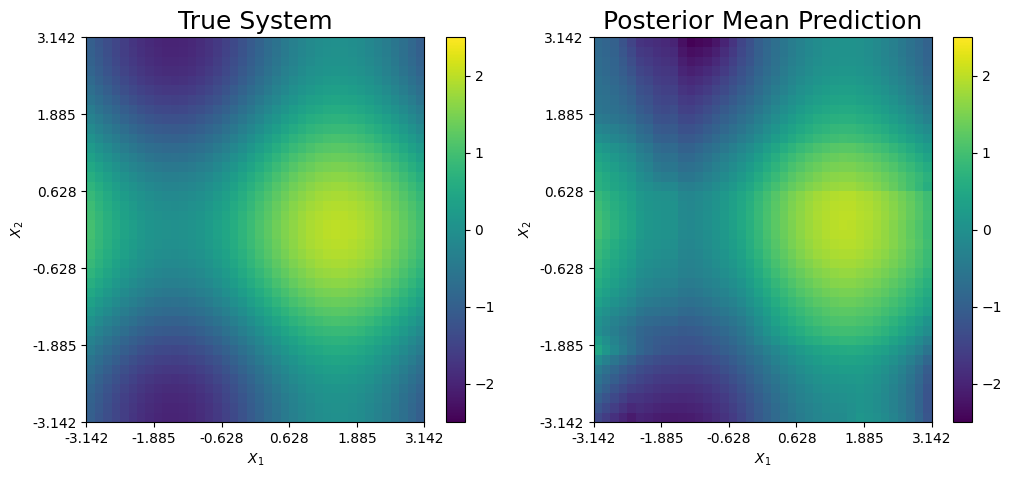

In [12]:
# Heat map comparing the surfaces
fig, ax = plt.subplots(1,2, figsize = (12,5))

pcm1 = ax[0].pcolormesh(f0_test.transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[0].set_title("True System", size = 18)
ax[0].set(xlabel = "$X_1$", ylabel = "$X_2$")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm1,ax = ax[0])


# Predicted mean
pcm2 = ax[1].pcolormesh(pmean.reshape(x1_test.shape).transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[1].set_title("Posterior Mean Prediction", size = 18)
ax[1].set(xlabel = "$X_1$", ylabel = "$X_2$")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm2,ax = ax[1])

The corresponding upper and lower bounds from the 95% credible interval of the prediction are shown below. It appears non-negligible uncertainty exists only across areas where at least one expansion diverges and minimal training data is present. This typcially occurs around the boundary of the domain. 

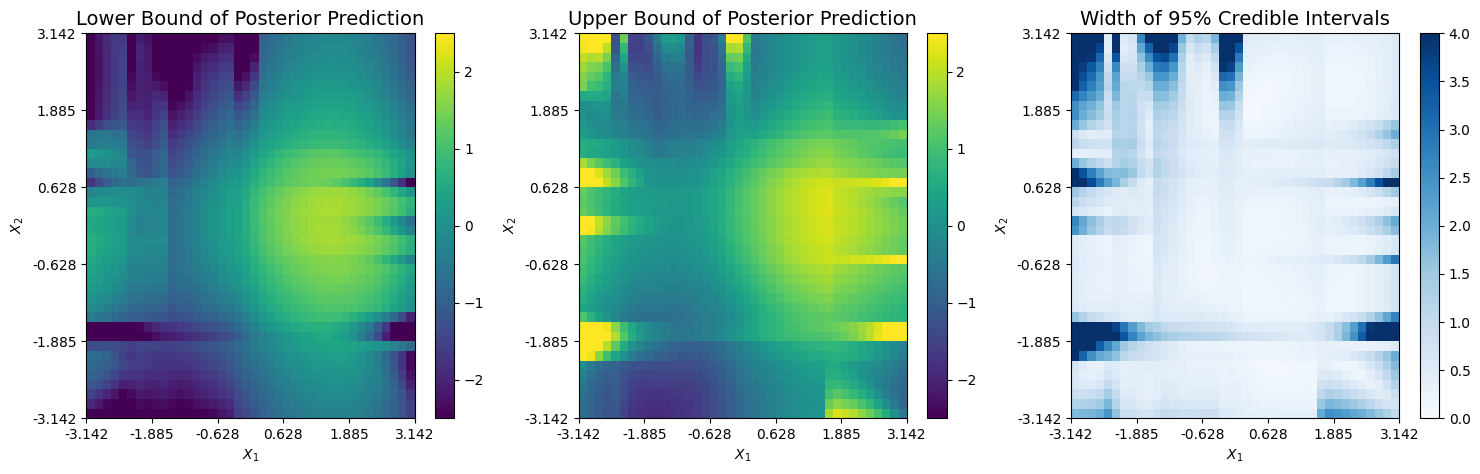

In [13]:
# Lower bound
cmap_blues = plt.get_cmap("Blues")
fig, ax = plt.subplots(1,3, figsize = (18,5))

pcm0 = ax[0].pcolormesh(pci[0].reshape(x1_test.shape).transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[0].set_title("Lower Bound of Posterior Prediction", size = 14)
ax[0].set(xlabel = "$X_1$", ylabel = "$X_2$")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm0,ax = ax[0])


# Upper bound
pcm1 = ax[1].pcolormesh(pci[1].reshape(x1_test.shape).transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[1].set_title("Upper Bound of Posterior Prediction", size = 14)
ax[1].set(xlabel = "$X_1$", ylabel = "$X_2$")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm1,ax = ax[1])


# CI Width
pcm2 = ax[2].pcolormesh((pci[1].reshape(x1_test.shape) - pci[0].reshape(x1_test.shape)).transpose(),cmap = cmap_blues, vmin = 0, vmax = 4)
ax[2].set_title("Width of 95% Credible Intervals", size = 14)
ax[2].set(xlabel = "$X_1$", ylabel = "$X_2$")
ax[2].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[2].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[2].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[2].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm2,ax = ax[2])


Finally, we can plot the mean residual, which is defined as $\hat{r}(x) = f_\dagger(x) - \hat{f}_\dagger(x)$. Only minimal error exists along the boundary of the domain.   

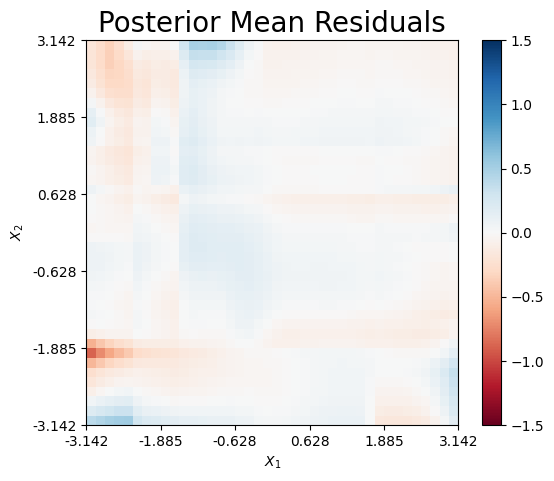

In [14]:
# Residual Plots
cmap_rb = plt.get_cmap("RdBu")
fig, ax = plt.subplots(1,1, figsize = (6,5))

pcm1 = ax.pcolormesh((f0_test - pmean.reshape(x1_test.shape)).transpose(),cmap = cmap_rb, vmin = -1.5, vmax = 1.5)
ax.set_title("Posterior Mean Residuals", size = 20)
ax.set(xlabel = "$X_1$", ylabel = "$X_2$")
ax.xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm1,ax = ax)


#### Weight Functions

The mean prediction of each weight function is shown below. Similar to the two model case, we see the weight functions take larger values in areas where the corresponding expansion is accurate. The third weight fails to take values above 0.4 in the upper left corner, which is where $h_3(x)$ is accurate. This likely occurs because the hihg-fidelity regions of $h_3(x)$ slighlty overlap with those from $h_1(x)$ and $h_2(x)$. 

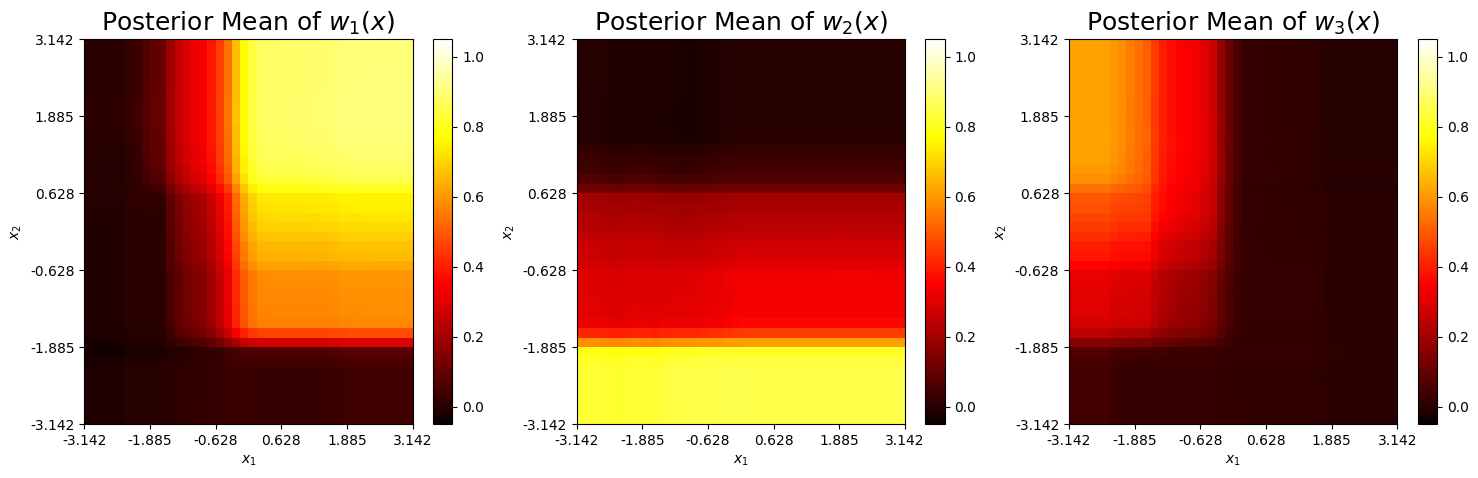

In [15]:
#sb.heatmap(wmean)
cmap_hot = plt.get_cmap('hot')

w1_mean = wmean.transpose()[0]
w1_mean = w1_mean.reshape(x1_test.shape).transpose()

w2_mean = wmean.transpose()[1]
w2_mean = w2_mean.reshape(x1_test.shape).transpose()

w3_mean = wmean.transpose()[2]
w3_mean = w3_mean.reshape(x1_test.shape).transpose()

fig, ax = plt.subplots(1,3, figsize = (18,5))
for i in range(3):
    wi_mean = wmean.transpose()[i]
    wi_mean = wi_mean.reshape(x1_test.shape).transpose()

    post_title = "Posterior Mean of $w_" + str(i+1) + "(x)$"
    pcm0 = ax[i].pcolormesh(wi_mean,cmap = cmap_hot, vmin = -0.05, vmax = 1.05)
    ax[i].set_title(post_title, size = 18)
    ax[i].set(xlabel = "$x_1$", ylabel = "$x_2$")
    ax[i].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
    ax[i].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
    ax[i].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
    ax[i].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
    fig.colorbar(pcm0,ax = ax[i])



#### Error Standard Deviation
Finally, the posterior distribution of the error variance is shown below. The resulting posterior concentrates about the true value of 0.1. This means, the error standard deviation is accurately recovered with small uncertainty. The true value of $\sigma = 0.10$ is accurately recovered from the BART-based model, as the posterior is nearly centered around 0.1.

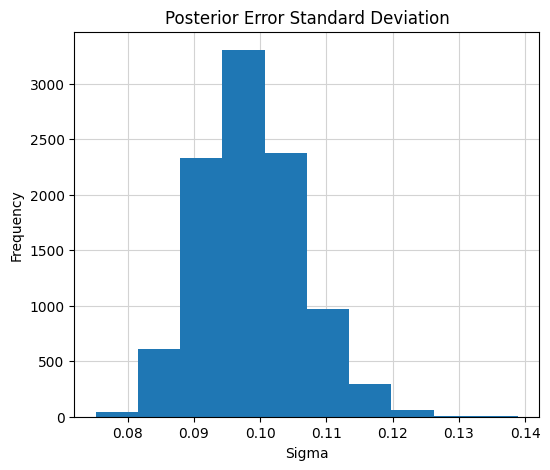

In [16]:
# Plot the posterior of the error standard deviation
mix.plot_sigma()